In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import time
import torch
from torch.optim import Adam
from torch.nn import MSELoss
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np

In [2]:
NEURAL_NETWORK_EPOCHS = [10, 50, 100, 200, 500]
SINUSOIDAL_POINTS = [10, 100, 200, 500, 1000]

In [3]:
def calculate_running_time(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        model = func(*args)
        end = time.time() - start
        print(f"Function runned in {end} seconds.")
        return model
    return wrapper

In [4]:
@calculate_running_time
def train_forest(X, y):
    model = RandomForestRegressor()
    model.fit(X, y)
    return model

In [5]:
class DeepLearningModel(nn.Module):
    def __init__(self, activation_function):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 16),
            activation_function(),
            nn.Linear(16, 32),
            activation_function(),
            nn.Linear(32, 64),
            activation_function(),
            nn.Linear(64, 32),
            activation_function(),
            nn.Linear(32, 16),
            activation_function(),
            nn.Linear(16, 8),
            activation_function(),
            nn.Linear(8, 1),
        )
        
        
    def forward(self, X):
        return self.layers(X)

In [6]:
class DataProvider(Dataset):
    def __init__(self, X, y):
        super().__init__()
        
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [7]:
def build_model(activation_function):
    return DeepLearningModel(activation_function)

In [8]:
def train_model_for_num_of_epochs(epochs: int, trained_models: dict, data: DataLoader):
    time_start = time.time()
    
    model_name = f"Model-{epochs}"
    loss_func = MSELoss()
    model = build_model(nn.ReLU)
    optimizer = Adam(model.parameters(), lr=0.0001)
    
    for epoch in range(epochs):
        for inp, out in data:
            optimizer.zero_grad()
            out = torch.unsqueeze(out, -1)
            prediction = model(inp)
            loss = loss_func(prediction, out)
            loss.backward()
            optimizer.step()
        
        
    print(f"Model name {model_name}: Loss: {loss.item()}")
    
    trained_models[model_name] = {
        "Time": (time.time() - time_start),
        "Epochs": epochs,
        "Model": model,
        "Optimizer": optimizer,
        "Loss function": loss_func
    }

In [9]:
def get_results(data: DataLoader, model: DeepLearningModel):
    loss_func = MSELoss()
    data_len = len(data)
    mse_sum = 0
    
    for inp, out in data:
        out = torch.unsqueeze(out, -1)
        preds = model(inp)
        loss = loss_func(preds, out)
        mse_sum += loss.item()
    
    mse = mse_sum / data_len
    
    return mse

In [10]:
def generate_noisy_sinusoidal_data(num_points):
    X = np.random.uniform(-2*np.pi, 2*np.pi, num_points)
    y = np.sin(X) + np.random.normal(0, 0.1, num_points)
    return X.reshape(-1, 1), y

In [11]:
sinusoidal_datasets = {num_points: generate_noisy_sinusoidal_data(num_points) for num_points in SINUSOIDAL_POINTS}

Function runned in 0.09199929237365723 seconds.
Num of points:10 | Error:0.08591955302586068
Function runned in 0.11299943923950195 seconds.
Num of points:100 | Error:0.002632617046345302
Function runned in 0.13399958610534668 seconds.
Num of points:200 | Error:0.0018702951670203783
Function runned in 0.19872760772705078 seconds.
Num of points:500 | Error:0.001991271161260587
Function runned in 0.31026768684387207 seconds.
Num of points:1000 | Error:0.001955406938608721


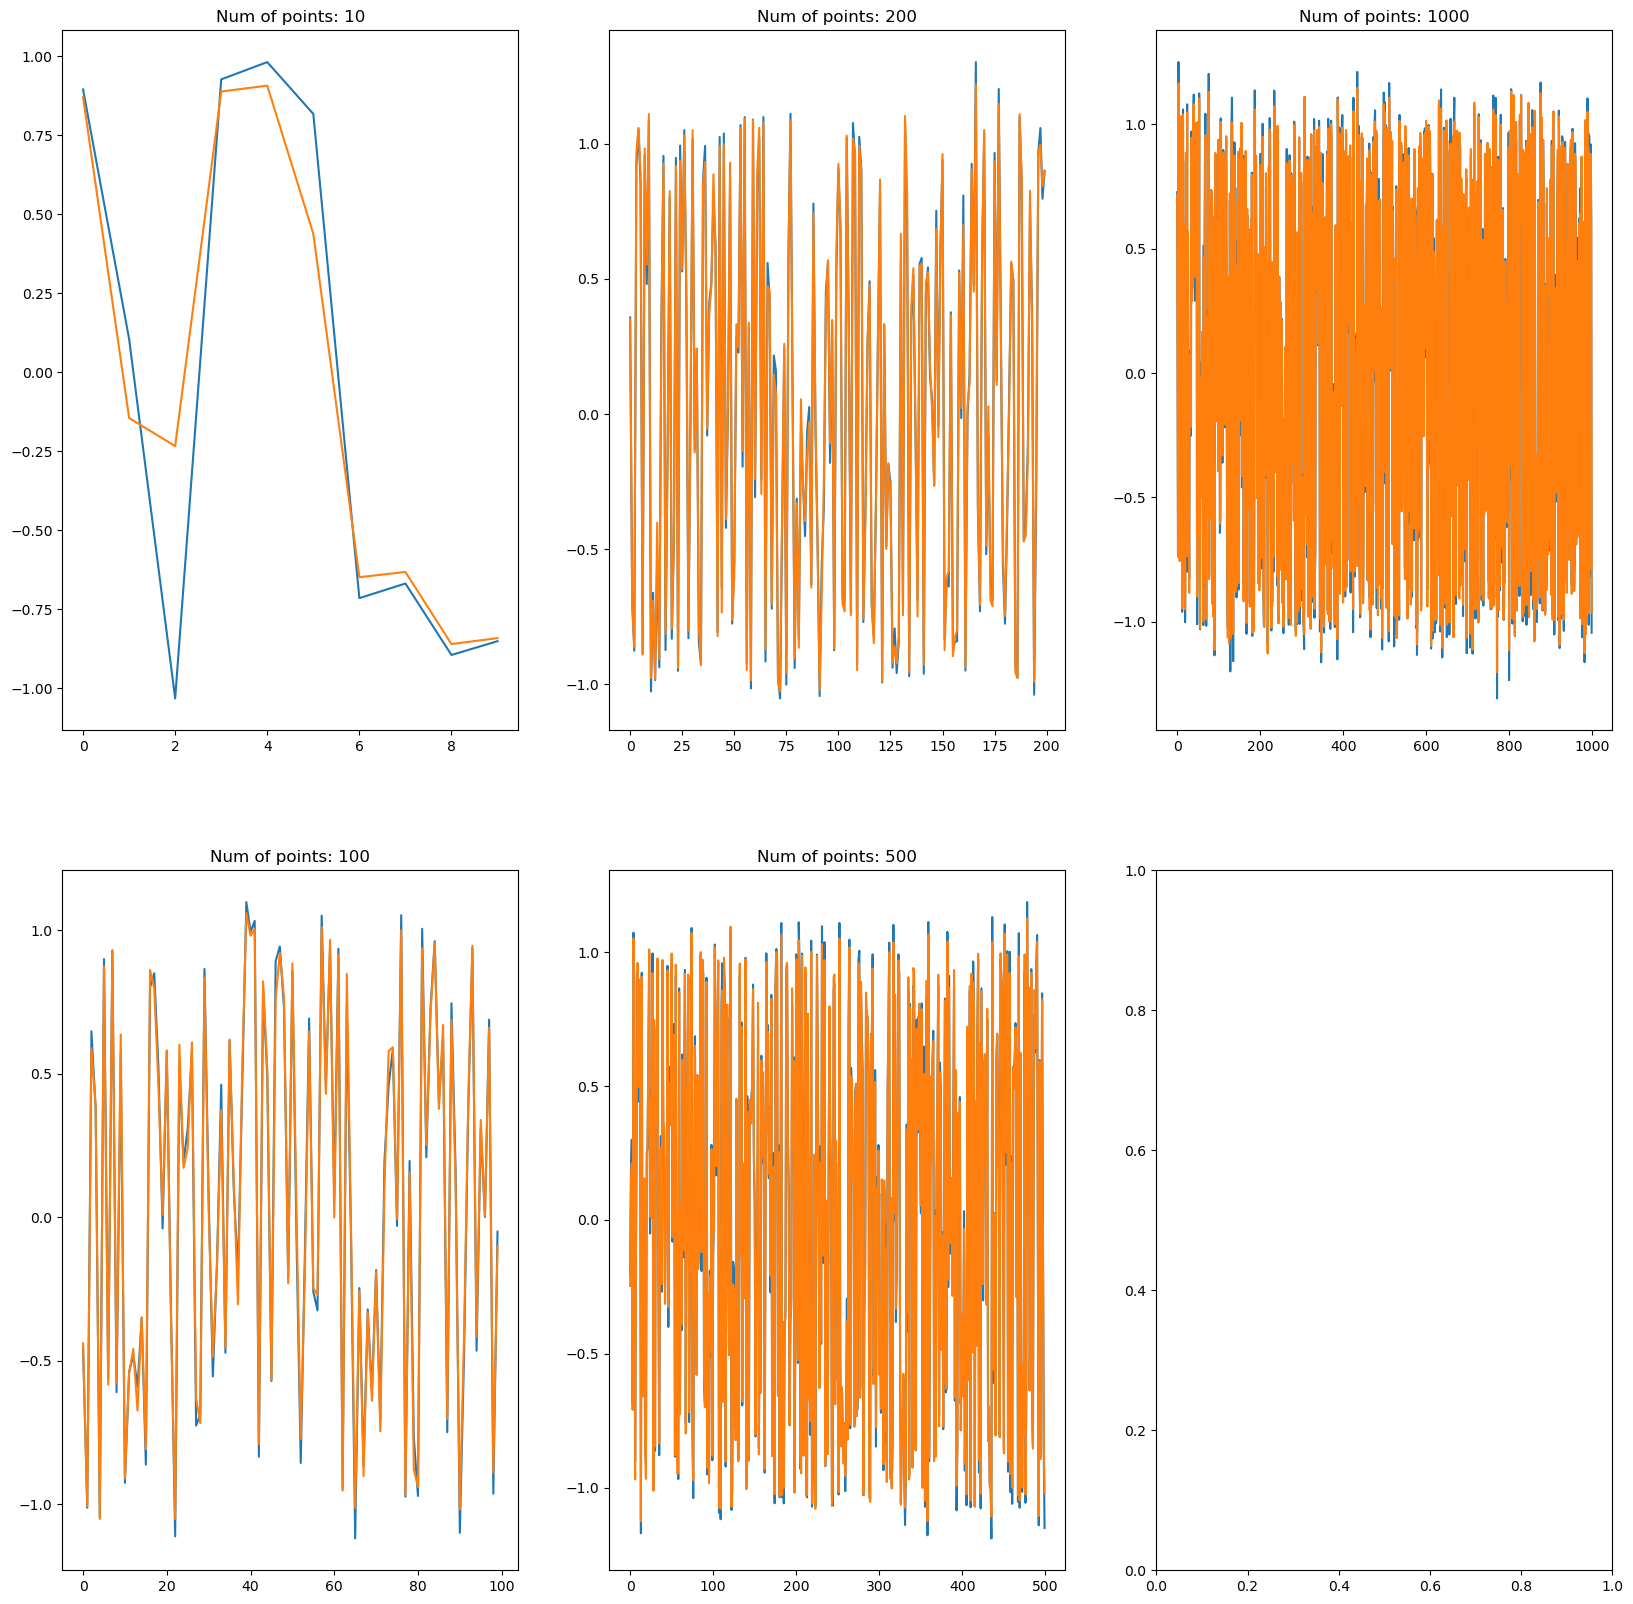

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(20, 20))
cols = 0
rows = 0
for num_of_points, (X, y) in sinusoidal_datasets.items():
    forest = train_forest(X, y)
    preds = forest.predict(X)
    axs[cols, rows].plot(y)
    axs[cols, rows].plot(preds)
    axs[cols, rows].set_title(f"Num of points: {num_of_points}")
    
    cols += 1
    if cols == 2:
        rows += 1
        cols = 0
        
    print(f"Num of points:{num_of_points} | Error:{mean_squared_error(y, preds)}")

In [13]:
data_loaders = {}

for num_of_points, (X, y) in sinusoidal_datasets.items():
    data_loaders[num_of_points] = DataLoader(DataProvider(X, y), batch_size=32, shuffle=False)

In [14]:
models = {}

In [15]:
for points_num, dataset in data_loaders.items():
    print("-"*30)
    for num_of_epochs in NEURAL_NETWORK_EPOCHS:
        print(f"Epochs:{num_of_epochs}|Points number: {points_num}")
        train_model_for_num_of_epochs(num_of_epochs, models, dataset)
        print(f'Results:{get_results(dataset, models[f"Model-{num_of_epochs}"]["Model"])}')
        print(models[f"Model-{num_of_epochs}"]["Time"], " time")
    print("-"*30)

------------------------------
Epochs:10|Points number: 10
Model name Model-10: Loss: 0.720840573310852
Results:0.720326840877533
0.41199779510498047  time
Epochs:50|Points number: 10
Model name Model-50: Loss: 0.710290789604187
Results:0.7100416421890259
0.0989985466003418  time
Epochs:100|Points number: 10
Model name Model-100: Loss: 0.7086859941482544
Results:0.7077232003211975
0.18800139427185059  time
Epochs:200|Points number: 10
Model name Model-200: Loss: 0.6800123453140259
Results:0.6793181300163269
0.3982882499694824  time
Epochs:500|Points number: 10
Model name Model-500: Loss: 0.13326525688171387
Results:0.13124528527259827
0.9529983997344971  time
------------------------------
------------------------------
Epochs:10|Points number: 100
Model name Model-10: Loss: 0.3298439383506775
Results:0.42672092467546463
0.07899999618530273  time
Epochs:50|Points number: 100
Model name Model-50: Loss: 0.37042853236198425
Results:0.38362859189510345
0.4100003242492676  time
Epochs:100|P